In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [9]:
# Descarga de datos
tickers = ["AAPL","MSFT","GOOGL","AMZN"]
weights = np.array([0.25,0.25,0.25,0.25])

end = dt.datetime.today()
start = end - dt.timedelta(days=365*3)

data = yf.download(tickers,start=start,end=end)["Close"]
returns = data.pct_change().dropna()

n_sim= 10000
n_days=252
n_assets=len(tickers)
returns



[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2023-02-22,0.002896,0.012793,-0.001525,-0.004591
2023-02-23,0.003291,0.000313,-0.008292,0.012962
2023-02-24,-0.018005,-0.024212,-0.019364,-0.021784
2023-02-27,0.008248,0.002781,0.008302,0.003772
2023-02-28,-0.003448,0.005013,0.002114,-0.002958
...,...,...,...,...
2026-02-12,-0.049982,-0.021952,-0.006303,-0.006257
2026-02-13,-0.022733,-0.004058,-0.010615,-0.001294
2026-02-17,0.031668,0.011872,-0.012103,-0.011113


In [8]:
# CALCULAR LA  VOLATILIDAD EWMA HISTORICA 
lambda_ = 0.94

ewma_var = returns.var().copy()
ewma_vol_series = []

for t in range(len(returns)):
    r_t = returns.iloc[t]
    ewma_var = lambda_ * ewma_var + (1 - lambda_) * (r_t ** 2)
    ewma_vol_series.append(np.sqrt(ewma_var))

ewma_vol_df = pd.DataFrame(ewma_vol_series, 
                           index=returns.index, 
                           columns=returns.columns)

In [6]:
# CORRELACIONES 
corr_matrix = returns.corr()
L_corr = np.linalg.cholesky(corr_matrix)

corr_matrix, L_corr

(Ticker      AAPL      AMZN     GOOGL      MSFT
 Ticker                                        
 AAPL    1.000000  0.450178  0.440102  0.440532
 AMZN    0.450178  1.000000  0.540656  0.570302
 GOOGL   0.440102  0.540656  1.000000  0.437541
 MSFT    0.440532  0.570302  0.437541  1.000000,
 array([[1.        , 0.        , 0.        , 0.        ],
        [0.45017785, 0.89293892, 0.        , 0.        ],
        [0.44010197, 0.38360057, 0.81188722, 0.        ],
        [0.44053217, 0.41658383, 0.10328988, 0.78849257]]))

In [12]:
#MONTECARLO VOLATILIDAD 


sigma_t=ewma_vol_df.iloc[-1].values
portfolio_paths=np.zeros((n_sim, n_days))
for s in range(n_sim):

    sigma = sigma_t.copy()
    prices_sim = np.ones(n_assets)

    for t in range(n_days):

        z = np.random.normal(size=n_assets)
        correlated = L_corr @ z

        r = sigma * correlated

        prices_sim = prices_sim * (1 + r)

        port_ret = np.dot(weights, r)

        if t == 0:
            portfolio_paths[s, t] = 1 + port_ret
        else:
            portfolio_paths[s, t] = portfolio_paths[s, t-1] * (1 + port_ret)

        sigma = np.sqrt(lambda_ * sigma**2 + (1 - lambda_) * (r**2))

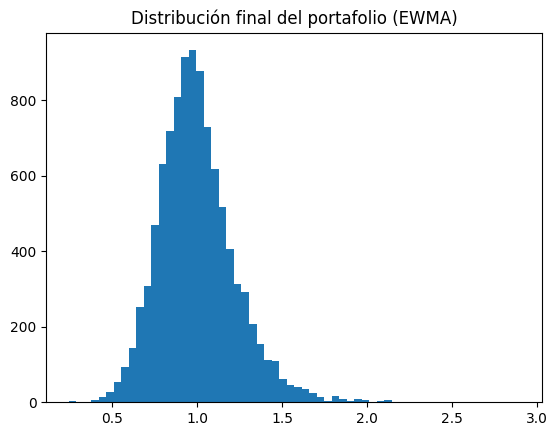

VaR 95%: 0.3274428141740441
Expected Shortfall 95%: 0.40549868878725415


In [19]:
final_values = portfolio_paths[:,-1]

plt.hist(final_values,bins=60)
plt.title("Distribución final del portafolio (EWMA)")
plt.show()

var_95 = np.percentile(final_values,5)
es_95 = final_values[final_values<=var_95].mean()

print("VaR 95%:",1-var_95)
print("Expected Shortfall 95%:",1-es_95)

# ACTIVIDAD

Con MGB con volatilidad constante (como en el checkpoint 3.)
- Usando 1 año de data histórica
- Usando 3 años de data histórica
- Usando 5 años de data histórica
- Usando 10 años de data histórica
- Con EWMA (como visto en clase)
- Usando 1 año de data histórica. Lambda =.94
- Usando 3 años de data histórica. Lambda =.94
- Usando 5 años de data histórica. Lambda =.94
- Usando 10 años de data histórica. Lambda =.94
- Con EWMA (como visto en clase) 
- Usando 1 año de data histórica. Lambda =.8
- Usando 3 años de data histórica. Lambda =.8
- Usando 5 años de data histórica. Lambda =.8



In [20]:
# lambda en la funcion debe ser como letra y no como paramero ya que lamda si es algo que identifica python 
def get_value_at_risk_jutnos(start, end, lambda_): 

    tickers = yf.download(
        ["AAPL","MSFT","GOOGL","AMZN"],
        start=start,
        end=end
    )["Close"]

    returns = tickers.pct_change().dropna()

    ewma_var = returns.var().copy()
    ewma_vol_series = []

    for t in range(len(returns)):
        r_t = returns.iloc[t]
        ewma_var = lambda_ * ewma_var + (1 - lambda_) * (r_t**2)
        ewma_vol_series.append(np.sqrt(ewma_var))

    ewma_vol_df = pd.DataFrame(
        ewma_vol_series,
        index=returns.index,
        columns=returns.columns
    )

    final_values = portfolio_paths[:,-1]
    var_95 = np.percentile(final_values,5)

    
    return 1-var_95

    




In [30]:
vol1 = get_value_at_risk_jutnos("2024-01-01", "2025-01-01", 0.94)
vol2= get_value_at_risk_jutnos("2023-01-01", "2026-01-01", 0.94)
vol3= get_value_at_risk_jutnos("2024-01-01", "2026-01-01", 0.94)
vol4= get_value_at_risk_jutnos("2016-01-01", "2026-01-01", 0.94)
vol5= get_value_at_risk_jutnos("2020-01-01", "2025-01-01", 0.94)
vol6= get_value_at_risk_jutnos("2024-01-01", "2025-01-01", 0.8)
vol7= get_value_at_risk_jutnos("2023-01-01", "2026-01-01", 0.8)
vol8= get_value_at_risk_jutnos("2024-01-01", "2026-01-01", 0.8)


print ( vol, vol2, vol3,vol4, vol5, vol6, vol7,vol8)




[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


0.3274428141740441 0.3274428141740441 0.3274428141740441 0.3274428141740441 0.3274428141740441 0.3274428141740441 0.3274428141740441 0.3274428141740441


 representa el value at risk  significa que el portafolio  puede perder en x tiempo  estas 95% seguro de que el portafolio no pierde mas de este porcietno 

In [32]:
tabla = pd.DataFrame({
    "var_95":[vol1,vol2,vol3,vol4,vol5,vol6,vol7,vol8]
})

print(tabla)

     var_95
0  0.327443
1  0.327443
2  0.327443
3  0.327443
4  0.327443
5  0.327443
6  0.327443
7  0.327443
